In [ ]:
# This is the code for calculating the window function kernels given in Eq. 57 and 88 of WadSco19
# and calculating the Gaussian covariance from them

In [45]:
import scipy, time
from scipy.fftpack import fft2, fftn, ifftn
from scipy.special import hyp2f1
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.io import FortranFile
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power, conj
import matplotlib
from matplotlib import pyplot as plt
import sys
import multiprocessing
from threading import Timer
%matplotlib inline

In [46]:
# for aesthetic plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=14
plt.rcParams["figure.figsize"] = [6.0,4.]
matplotlib.rc('text', usetex=True)

In [47]:
# Total number of k-bins in power spectrum
nBins=50

kBinWidth=0.005

# Length of box used when computing FFTs
Lbox=3750.

# Fundamental k-mode
kfun=2.*np.pi/Lbox

kbinEdges=np.arange(nBins+1)*kBinWidth

In [48]:
I22=874.224835580588 # Eq.3

dire='/Users/digvijay/Dropbox/Drop_Acad/Roman/Covariance/data/Public/'

In [ ]:
# The files for FFTs form the random catalog have been generated in Fortran.
# I'm figuring out a way to calculate them in python but until then
# please download the files from the link:
# https://drive.google.com/drive/folders/1bWKfUaIXcC1n-2hk9KtKhqukxTH1379i?usp=sharing

In [49]:
# First rewriting the FFT array so that the zero mode is at the center (negative k to left of it and positive to right)
# This is done so that dot products of the FFTs with k-hat can be conveniently taken later 

# As the window falls steeply with k, only low-k regions are needed for the calculation.
# Therefore cutting out the high-k modes in the FFTs using the icut parameter
icut=15; # needs to be less than Lm//2 (Lm: size of FFT)

def fft(temp):
    ia=Lm//2-1; ib=Lm//2+1
    temp2=np.zeros((Lm,Lm,Lm),dtype='<c8')
    temp2[ia:Lm,ia:Lm,ia:Lm]=temp[0:ib,0:ib,0:ib]; temp2[0:ia,ia:Lm,ia:Lm]=temp[ib:Lm,0:ib,0:ib]
    temp2[ia:Lm,0:ia,ia:Lm]=temp[0:ib,ib:Lm,0:ib]; temp2[ia:Lm,ia:Lm,0:ia]=temp[0:ib,0:ib,ib:Lm]
    temp2[0:ia,0:ia,ia:Lm]=temp[ib:Lm,ib:Lm,0:ib]; temp2[0:ia,ia:Lm,0:ia]=temp[ib:Lm,0:ib,ib:Lm]
    temp2[ia:Lm,0:ia,0:ia]=temp[0:ib,ib:Lm,ib:Lm]; temp2[0:ia,0:ia,0:ia]=temp[ib:Lm,ib:Lm,ib:Lm]
    
    temp2=temp2[ia-icut:ia+icut+1,ia-icut:ia+icut+1,ia-icut:ia+icut+1]
    
    if(W22_flag): return(temp2)
    else: return(conj(temp2))

In [50]:
# Reading the FFT files for W22 (referred to as W for brevity)
# Wc refers to conjugate of W
f = FortranFile(dire+'FFTWinFun_HighZ_W22_NGC', 'r')
Lm=f.read_record('<i4'); Lm=Lm[0]; #Lm: size of FFT
print('FFT size is',Lm)
W22_flag=1
W=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxxx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyyyy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzzzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxxy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxxz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyyyx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyyyz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzzzx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzzzy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxyy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyyzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wxxyz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wyyxz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
Wzzxy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)

FFT size is 48


In [51]:
# For W12 instead of W22 above
f = FortranFile(dire+'FFTWinFun_HighZ_W12_NGC', 'r')
Lm=f.read_record('<i4'); Lm=Lm[0];
W22_flag=0
W12=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxxx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yyyy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zzzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxxy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxxz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yyyx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yyyz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zzzx=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zzzy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxyy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yyzz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12xxyz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12yyxz=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)
W12zzxy=fft(f.read_record('('+str(Lm)+','+str(Lm)+','+str(Lm)+')<c8').T)

In [18]:
# Recording the k-modes in different shells
# Bin_kmodes contains [kx,ky,kz,radius] values of all the modes in the bin

Lm2 = np.int(kBinWidth*nBins/kfun)+1
[ix,iy,iz] = np.zeros((3,2*Lm2+1,2*Lm2+1,2*Lm2+1));
Bin_kmodes=[]; Bin_ModeNum=np.zeros(nBins,dtype=int)

for i in range(nBins): Bin_kmodes.append([])
for i in range(len(ix)):
    ix[i,:,:]+=i-Lm2; iy[:,i,:]+=i-Lm2; iz[:,:,i]+=i-Lm2

rk=np.sqrt(ix**2+iy**2+iz**2)
sort=(rk*kfun/kBinWidth).astype(int)

for i in range(0,nBins):
    ind=(sort==i); Bin_ModeNum[i]=len(ix[ind]); \
    Bin_kmodes[i]=np.hstack((ix[ind].reshape(-1,1),iy[ind].reshape(-1,1),iz[ind].reshape(-1,1),rk[ind].reshape(-1,1)))

In [19]:
# First I'm only showing only the code for the monopole covariance so the code is relatively easy
# to understand. The quadrupole and hexadecapole autocovariance is given below and involves more FFTs

def WinFun_onlyC00(Nbin):
    avgW00=np.zeros((2*3+1,15),dtype='<c8');
    [ix,iy,iz,k2xh,k2yh,k2zh]=np.zeros((6,2*icut+1,2*icut+1,2*icut+1))
    
    # Arrays with zero at the center (similar to FFTs earlier)
    for i in range(2*icut+1): 
        ix[i,:,:]+=i-icut; iy[:,i,:]+=i-icut; iz[:,:,i]+=i-icut
    
    # We will not use all the modes in the k1 shell but will sample only a few (kmodes_sampled)
    if (kmodes_sampled<Bin_ModeNum[Nbin]): # check if no. of modes in the shell are more than kmodes_sampled
        norm=kmodes_sampled
        sampled=(np.random.rand(kmodes_sampled)*Bin_ModeNum[Nbin]).astype(int)
    else:
        norm=Bin_ModeNum[Nbin]
        sampled=np.arange(Bin_ModeNum[Nbin],dtype=int)
        
    # Randomly select modes in the k1 bin and add all their contributions in the end
    for n in sampled:
        [ik1x,ik1y,ik1z,rk1]=Bin_kmodes[Nbin][n]
        if (rk1==0.): k1xh=0; k1yh=0; k1zh=0 # If |k1|=0
        else: k1xh=ik1x/rk1; k1yh=ik1y/rk1; k1zh=ik1z/rk1
        
    # Build a 3D array of k2 modes around the selected mode
    # Only k2 modes in a cube centered at the sampled k1 vector are used
        k2xh=ik1x-ix; k2yh=ik1y-iy; k2zh=ik1z-iz;
        rk2 = np.sqrt(k2xh**2+k2yh**2+k2zh**2);
        sort = (rk2*kfun/kBinWidth).astype(int)-Nbin # to decide later which shell the k2 mode belongs to
        ind=(rk2==0); # If |k2|=0
        if (ind.any()>0): rk2[ind]=1e10 
        k2xh/=rk2; k2yh/=rk2; k2zh/=rk2;
        #k2 hat arrays built
        
    # Now calculating window multipole kernels by taking dot products of cartesian FFTs with k1-hat, k2-hat arrays
    # W corresponds to W22(k) and Wc corresponds to conjugate of W22(k)
    # L(i) refers to multipoles
        
        W_L0 = W
        Wc_L0 = conj(W)
        
        xx=Wxx*k1xh**2+Wyy*k1yh**2+Wzz*k1zh**2+2.*Wxy*k1xh*k1yh+2.*Wyz*k1yh*k1zh+2.*Wzx*k1zh*k1xh
        
        W_k1L2=1.5*xx-0.5*W
        W_k2L2=1.5*(Wxx*k2xh**2+Wyy*k2yh**2+Wzz*k2zh**2 \
        +2.*Wxy*k2xh*k2yh+2.*Wyz*k2yh*k2zh+2.*Wzx*k2zh*k2xh)-0.5*W
        Wc_k1L2=conj(W_k1L2)
        Wc_k2L2=conj(W_k2L2)
        
        W_k1L4=35./8.*(Wxxxx*k1xh**4 +Wyyyy*k1yh**4+Wzzzz*k1zh**4 \
                +4.*Wxxxy*k1xh**3*k1yh +4.*Wxxxz*k1xh**3*k1zh +4.*Wyyyx*k1yh**3*k1xh \
                +4.*Wyyyz*k1yh**3*k1zh +4.*Wzzzx*k1zh**3*k1xh +4.*Wzzzy*k1zh**3*k1yh \
                +6.*Wxxyy*k1xh**2*k1yh**2+6.*Wxxzz*k1xh**2*k1zh**2+6.*Wyyzz*k1yh**2*k1zh**2 \
                +12.*Wxxyz*k1xh**2*k1yh*k1zh+12.*Wyyxz*k1yh**2*k1xh*k1zh +12.*Wzzxy*k1zh**2*k1xh*k1yh) \
                -5./2.*W_k1L2 -7./8.*W_L0
        Wc_k1L4=conj(W_k1L4)
        
        W_k2L4=35./8.*(Wxxxx*k2xh**4 +Wyyyy*k2yh**4+Wzzzz*k2zh**4 \
                 +4.*Wxxxy*k2xh**3*k2yh +4.*Wxxxz*k2xh**3*k2zh +4.*Wyyyx*k2yh**3*k2xh \
                 +4.*Wyyyz*k2yh**3*k2zh +4.*Wzzzx*k2zh**3*k2xh +4.*Wzzzy*k2zh**3*k2yh \
                 +6.*Wxxyy*k2xh**2*k2yh**2+6.*Wxxzz*k2xh**2*k2zh**2+6.*Wyyzz*k2yh**2*k2zh**2 \
                 +12.*Wxxyz*k2xh**2*k2yh*k2zh+12.*Wyyxz*k2yh**2*k2xh*k2zh +12.*Wzzxy*k2zh**2*k2xh*k2yh) \
                 -5./2.*W_k2L2 -7./8.*W_L0
        Wc_k2L4=conj(W_k2L4)
    
        W12_L0 = W12
        
        # Collecting all kernels, will be multiplied by power multipoles later in function 'Wij'
        C00exp = [Wc_L0*W_L0,Wc_L0*W_k2L2,Wc_L0*W_k2L4,\
                Wc_k1L2*W_L0,Wc_k1L2*W_k2L2,Wc_k1L2*W_k2L4,\
                Wc_k1L4*W_L0,Wc_k1L4*W_k2L2,Wc_k1L4*W_k2L4]
        
        # Including shot noise terms
        C00exp += [2.*W_L0*W12_L0,W_k1L2*W12_L0,W_k1L4*W12_L0,\
                W_k2L2*W12_L0,W_k2L4*W12_L0,\
                conj(W12_L0)*W12_L0] # 1/nbar^2
        
        # Adding contributions to different k-bins (3 on each side of the diagonal)
        for i in range(-3,4):
            ind=(sort==i);
            for j in range(15):
                avgW00[i+3,j]+=np.sum(C00exp[j][ind])
            
    for i in range(0,2*3+1):
        if(i+Nbin-3>=nBins): avgW00[i]*=0; continue #Checking for k-bins not within the range(0,nBins)
        if(i+Nbin-3<0): avgW00[i]*=0; continue
        avgW00[i]=avgW00[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        
    avgW00=2.*np.real(avgW00); 
    return(avgW00)

In [58]:
# Gives window kernels for L=0,2,4 auto (instead of only L=0 above)

# Returns an array with [7,15,3] dimensions. 
#    The first dim corresponds to the k-bin of k2 
#    (only 3 bins on each side of diagonal are included as the Gaussian covariance drops quickly away from diagonal)

#    The second dim corresponds to elements to be multiplied by various power spectrum multipoles
#    to obtain the final covariance (see function 'Wij' below)

#    The last dim corresponds to multipole (L0,L2,L4)

def WinFun(Nbin):
    avgWij=np.zeros((2*3+1,15,6)); avgW00=np.zeros((2*3+1,15),dtype='<c8');
    avgW22=avgW00.copy(); avgW44=avgW00.copy(); avgW20=avgW00.copy(); avgW40=avgW00.copy(); avgW42=avgW00.copy()
    [ix,iy,iz,k2xh,k2yh,k2zh]=np.zeros((6,2*icut+1,2*icut+1,2*icut+1))
    
    for i in range(2*icut+1): 
        ix[i,:,:]+=i-icut; iy[:,i,:]+=i-icut; iz[:,:,i]+=i-icut
        
    if (kmodes_sampled<Bin_ModeNum[Nbin]):
        norm=kmodes_sampled
        sampled=(np.random.rand(kmodes_sampled)*Bin_ModeNum[Nbin]).astype(int)
    else:
        norm=Bin_ModeNum[Nbin]
        sampled=np.arange(Bin_ModeNum[Nbin],dtype=int)
    
    # Randomly select a mode in the k1 bin
    for n in sampled:
        [ik1x,ik1y,ik1z,rk1]=Bin_kmodes[Nbin][n]
        if (rk1==0.): k1xh=0; k1yh=0; k1zh=0
        else: k1xh=ik1x/rk1; k1yh=ik1y/rk1; k1zh=ik1z/rk1
            
    # Build a 3D array of modes around the selected mode   
        k2xh=ik1x-ix; k2yh=ik1y-iy; k2zh=ik1z-iz;
        rk2=np.sqrt(k2xh**2+k2yh**2+k2zh**2);
        sort=(rk2*kfun/kBinWidth).astype(int)-Nbin # to decide later which shell the k2 mode belongs to
        ind=(rk2==0);
        if (ind.any()>0): rk2[ind]=1e10
        k2xh/=rk2; k2yh/=rk2; k2zh/=rk2;
        #k2 hat arrays built
        
    # Now calculating window multipole kernels by taking dot products of cartesian FFTs with k1-hat, k2-hat arrays
    # W corresponds to W22(k) and Wc corresponds to conjugate of W22(k)
    # L(i) refers to multipoles
        
        W_L0 = W
        Wc_L0 = conj(W)
        
        xx=Wxx*k1xh**2+Wyy*k1yh**2+Wzz*k1zh**2+2.*Wxy*k1xh*k1yh+2.*Wyz*k1yh*k1zh+2.*Wzx*k1zh*k1xh
        
        W_k1L2=1.5*xx-0.5*W
        W_k2L2=1.5*(Wxx*k2xh**2+Wyy*k2yh**2+Wzz*k2zh**2 \
        +2.*Wxy*k2xh*k2yh+2.*Wyz*k2yh*k2zh+2.*Wzx*k2zh*k2xh)-0.5*W
        Wc_k1L2=conj(W_k1L2)
        Wc_k2L2=conj(W_k2L2)
        
        W_k1L4=35./8.*(Wxxxx*k1xh**4 +Wyyyy*k1yh**4+Wzzzz*k1zh**4 \
     +4.*Wxxxy*k1xh**3*k1yh +4.*Wxxxz*k1xh**3*k1zh +4.*Wyyyx*k1yh**3*k1xh \
     +4.*Wyyyz*k1yh**3*k1zh +4.*Wzzzx*k1zh**3*k1xh +4.*Wzzzy*k1zh**3*k1yh \
     +6.*Wxxyy*k1xh**2*k1yh**2+6.*Wxxzz*k1xh**2*k1zh**2+6.*Wyyzz*k1yh**2*k1zh**2 \
     +12.*Wxxyz*k1xh**2*k1yh*k1zh+12.*Wyyxz*k1yh**2*k1xh*k1zh +12.*Wzzxy*k1zh**2*k1xh*k1yh) \
     -5./2.*W_k1L2 -7./8.*W_L0
        Wc_k1L4=conj(W_k1L4)
        
        k1k2=Wxxxx*(k1xh*k2xh)**2+Wyyyy*(k1yh*k2yh)**2+Wzzzz*(k1zh*k2zh)**2 \
            +Wxxxy*(k1xh*k1yh*k2xh**2+k1xh**2*k2xh*k2yh)*2\
            +Wxxxz*(k1xh*k1zh*k2xh**2+k1xh**2*k2xh*k2zh)*2\
            +Wyyyz*(k1yh*k1zh*k2yh**2+k1yh**2*k2yh*k2zh)*2\
            +Wzzzy*(k1zh*k1yh*k2zh**2+k1zh**2*k2zh*k2yh)*2\
            +Wyyyx*(k1yh*k1xh*k2yh**2+k1yh**2*k2yh*k2xh)*2\
            +Wzzzx*(k1zh*k1xh*k2zh**2+k1zh**2*k2zh*k2xh)*2\
            +Wxxyy*(k1xh**2*k2yh**2+k1yh**2*k2xh**2+4.*k1xh*k1yh*k2xh*k2yh)\
            +Wxxzz*(k1xh**2*k2zh**2+k1zh**2*k2xh**2+4.*k1xh*k1zh*k2xh*k2zh)\
            +Wyyzz*(k1yh**2*k2zh**2+k1zh**2*k2yh**2+4.*k1yh*k1zh*k2yh*k2zh)\
            +Wyyxz*(k1xh*k1zh*k2yh**2+k1yh**2*k2xh*k2zh+2.*k1yh*k2yh*(k1zh*k2xh+k1xh*k2zh))*2\
            +Wxxyz*(k1yh*k1zh*k2xh**2+k1xh**2*k2yh*k2zh+2.*k1xh*k2xh*(k1zh*k2yh+k1yh*k2zh))*2\
            +Wzzxy*(k1yh*k1xh*k2zh**2+k1zh**2*k2yh*k2xh+2.*k1zh*k2zh*(k1xh*k2yh+k1yh*k2xh))*2
        
        W_k2L4=35./8.*(Wxxxx*k2xh**4 +Wyyyy*k2yh**4+Wzzzz*k2zh**4 \
     +4.*Wxxxy*k2xh**3*k2yh +4.*Wxxxz*k2xh**3*k2zh +4.*Wyyyx*k2yh**3*k2xh \
     +4.*Wyyyz*k2yh**3*k2zh +4.*Wzzzx*k2zh**3*k2xh +4.*Wzzzy*k2zh**3*k2yh \
     +6.*Wxxyy*k2xh**2*k2yh**2+6.*Wxxzz*k2xh**2*k2zh**2+6.*Wyyzz*k2yh**2*k2zh**2 \
     +12.*Wxxyz*k2xh**2*k2yh*k2zh+12.*Wyyxz*k2yh**2*k2xh*k2zh +12.*Wzzxy*k2zh**2*k2xh*k2yh) \
     -5./2.*W_k2L2 -7./8.*W_L0
        Wc_k2L4=conj(W_k2L4)
        
        W_k1L2_k2L2= 9./4.*k1k2 -3./4.*xx -1./2.*W_k2L2
        W_k1L2_k2L4=2/7.*W_k1L2+20/77.*W_k1L4 #approximate as 6th order FFTs not simulated
        W_k1L4_k2L2=W_k1L2_k2L4 #approximate
        W_k1L4_k2L4=1/9.*W_L0+100/693.*W_k1L2+162/1001.*W_k1L4
        Wc_k1L2_k2L2= conj(W_k1L2_k2L2)
        Wc_k1L2_k2L4=conj(W_k1L2_k2L4); Wc_k1L4_k2L2=Wc_k1L2_k2L4
        Wc_k1L4_k2L4=conj(W_k1L4_k2L4)
        
        k1k2W12=W12xxxx*(k1xh*k2xh)**2+W12yyyy*(k1yh*k2yh)**2+W12zzzz*(k1zh*k2zh)**2 \
            +W12xxxy*(k1xh*k1yh*k2xh**2+k1xh**2*k2xh*k2yh)*2\
            +W12xxxz*(k1xh*k1zh*k2xh**2+k1xh**2*k2xh*k2zh)*2\
            +W12yyyz*(k1yh*k1zh*k2yh**2+k1yh**2*k2yh*k2zh)*2\
            +W12zzzy*(k1zh*k1yh*k2zh**2+k1zh**2*k2zh*k2yh)*2\
            +W12yyyx*(k1yh*k1xh*k2yh**2+k1yh**2*k2yh*k2xh)*2\
            +W12zzzx*(k1zh*k1xh*k2zh**2+k1zh**2*k2zh*k2xh)*2\
            +W12xxyy*(k1xh**2*k2yh**2+k1yh**2*k2xh**2+4.*k1xh*k1yh*k2xh*k2yh)\
            +W12xxzz*(k1xh**2*k2zh**2+k1zh**2*k2xh**2+4.*k1xh*k1zh*k2xh*k2zh)\
            +W12yyzz*(k1yh**2*k2zh**2+k1zh**2*k2yh**2+4.*k1yh*k1zh*k2yh*k2zh)\
            +W12yyxz*(k1xh*k1zh*k2yh**2+k1yh**2*k2xh*k2zh+2.*k1yh*k2yh*(k1zh*k2xh+k1xh*k2zh))*2\
            +W12xxyz*(k1yh*k1zh*k2xh**2+k1xh**2*k2yh*k2zh+2.*k1xh*k2xh*(k1zh*k2yh+k1yh*k2zh))*2\
            +W12zzxy*(k1yh*k1xh*k2zh**2+k1zh**2*k2yh*k2xh+2.*k1zh*k2zh*(k1xh*k2yh+k1yh*k2xh))*2
        
        xxW12=W12xx*k1xh**2+W12yy*k1yh**2+W12zz*k1zh**2+2.*W12xy*k1xh*k1yh+2.*W12yz*k1yh*k1zh+2.*W12zx*k1zh*k1xh
    
        W12_L0 = W12
        W12_k1L2=1.5*xxW12-0.5*W12
        W12_k1L4=35./8.*(W12xxxx*k1xh**4 +W12yyyy*k1yh**4+W12zzzz*k1zh**4 \
     +4.*W12xxxy*k1xh**3*k1yh +4.*W12xxxz*k1xh**3*k1zh +4.*W12yyyx*k1yh**3*k1xh \
     +6.*W12xxyy*k1xh**2*k1yh**2+6.*W12xxzz*k1xh**2*k1zh**2+6.*W12yyzz*k1yh**2*k1zh**2 \
     +12.*W12xxyz*k1xh**2*k1yh*k1zh+12.*W12yyxz*k1yh**2*k1xh*k1zh +12.*W12zzxy*k1zh**2*k1xh*k1yh) \
     -5./2.*W12_k1L2 -7./8.*W12_L0
        W12_k1L4_k2L2=2/7.*W12_k1L2+20/77.*W12_k1L4
        W12_k1L4_k2L4=1/9.*W12_L0+100/693.*W12_k1L2+162/1001.*W12_k1L4
        W12_k2L2=1.5*(W12xx*k2xh**2+W12yy*k2yh**2+W12zz*k2zh**2\
        +2.*W12xy*k2xh*k2yh+2.*W12yz*k2yh*k2zh+2.*W12zx*k2zh*k2xh)-0.5*W12
        W12_k2L4=35./8.*(W12xxxx*k2xh**4 +W12yyyy*k2yh**4+W12zzzz*k2zh**4 \
     +4.*W12xxxy*k2xh**3*k2yh +4.*W12xxxz*k2xh**3*k2zh +4.*W12yyyx*k2yh**3*k2xh \
     +4.*W12yyyz*k2yh**3*k2zh +4.*W12zzzx*k2zh**3*k2xh +4.*W12zzzy*k2zh**3*k2yh \
     +6.*W12xxyy*k2xh**2*k2yh**2+6.*W12xxzz*k2xh**2*k2zh**2+6.*W12yyzz*k2yh**2*k2zh**2 \
     +12.*W12xxyz*k2xh**2*k2yh*k2zh+12.*W12yyxz*k2yh**2*k2xh*k2zh +12.*W12zzxy*k2zh**2*k2xh*k2yh) \
     -5./2.*W12_k2L2 -7./8.*W12_L0
        
        W12_k1L2_k2L2= 9./4.*k1k2W12 -3./4.*xxW12 -1./2.*W12_k2L2
        
        W_k1L2_Sumk2L22=1/5.*W_k1L2+2/7.*W_k1L2_k2L2+18/35.*W_k1L2_k2L4
        W_k1L2_Sumk2L24=2/7.*W_k1L2_k2L2+20/77.*W_k1L2_k2L4
        W_k1L4_Sumk2L22=1/5.*W_k1L4+2/7.*W_k1L4_k2L2+18/35.*W_k1L4_k2L4
        W_k1L4_Sumk2L24=2/7.*W_k1L4_k2L2+20/77.*W_k1L4_k2L4
        W_k1L4_Sumk2L44=1/9.*W_k1L4+100/693.*W_k1L4_k2L2+162/1001.*W_k1L4_k2L4
        
        C00exp = [Wc_L0*W_L0,Wc_L0*W_k2L2,Wc_L0*W_k2L4,\
                Wc_k1L2*W_L0,Wc_k1L2*W_k2L2,Wc_k1L2*W_k2L4,\
                Wc_k1L4*W_L0,Wc_k1L4*W_k2L2,Wc_k1L4*W_k2L4]
        
        C00exp += [2.*W_L0*W12_L0,W_k1L2*W12_L0,W_k1L4*W12_L0,\
                W_k2L2*W12_L0,W_k2L4*W12_L0,conj(W12_L0)*W12_L0]
        
        C22exp = [Wc_k2L2*W_k1L2 + Wc_L0*W_k1L2_k2L2,\
                Wc_k2L2*W_k1L2_k2L2 + Wc_L0*W_k1L2_Sumk2L22,\
                Wc_k2L2*W_k1L2_k2L4 + Wc_L0*W_k1L2_Sumk2L24,\
                Wc_k1L2_k2L2*W_k1L2 + Wc_k1L2*W_k1L2_k2L2,\
                Wc_k1L2_k2L2*W_k1L2_k2L2 + Wc_k1L2*W_k1L2_Sumk2L22,\
                Wc_k1L2_k2L2*W_k1L2_k2L4 + Wc_k1L2*W_k1L2_Sumk2L24,\
                Wc_k1L4_k2L2*W_k1L2 + Wc_k1L4*W_k1L2_k2L2,\
                Wc_k1L4_k2L2*W_k1L2_k2L2 + Wc_k1L4*W_k1L2_Sumk2L22,\
                Wc_k1L4_k2L2*W_k1L2_k2L4 + Wc_k1L4*W_k1L2_Sumk2L24]
        
        C22exp += [W_k1L2*W12_k2L2 + W_k2L2*W12_k1L2\
                   +W_k1L2_k2L2*W12_L0+W_L0*W12_k1L2_k2L2,\
                 0.5*((1/5.*W_L0+2/7.*W_k1L2+18/35.*W_k1L4)*W12_k2L2 + W_k1L2_k2L2*W12_k1L2\
+(1/5.*W_k2L2+2/7.*W_k1L2_k2L2+18/35.*W_k1L4_k2L2)*W12_L0 + W_k1L2*W12_k1L2_k2L2),\
    0.5*((2/7.*W_k1L2+20/77.*W_k1L4)*W12_k2L2 + W_k1L4_k2L2*W12_k1L2\
+(2/7.*W_k1L2_k2L2+20/77.*W_k1L4_k2L2)*W12_L0 + W_k1L4*W12_k1L2_k2L2),\
0.5*(W_k1L2_k2L2*W12_k2L2+(1/5.*W_L0+2/7.*W_k2L2+18/35.*W_k2L4)*W12_k1L2\
+(1/5.*W_k1L2+2/7.*W_k1L2_k2L2+18/35.*W_k1L2_k2L4)*W12_L0 + W_k2L2*W12_k1L2_k2L2),\
0.5*(W_k1L2_k2L4*W12_k2L2+(2/7.*W_k2L2+20/77.*W_k2L4)*W12_k1L2\
+(2/7.*W_k1L2_k2L2+20/77.*W_k1L2_k2L4)*W12_L0 + W_k2L4*W12_k1L2_k2L2),\
                 conj(W12_k1L2_k2L2)*W12_L0+conj(W12_k1L2)*W12_k2L2]
        
        C44exp = [Wc_k2L4*W_k1L4 + Wc_L0*W_k1L4_k2L4,\
                Wc_k2L4*W_k1L4_k2L2 + Wc_L0*W_k1L4_Sumk2L24,\
                Wc_k2L4*W_k1L4_k2L4 + Wc_L0*W_k1L4_Sumk2L44,\
                Wc_k1L2_k2L4*W_k1L4 + Wc_k1L2*W_k1L4_k2L4,\
                Wc_k1L2_k2L4*W_k1L4_k2L2 + Wc_k1L2*W_k1L4_Sumk2L24,\
                Wc_k1L2_k2L4*W_k1L4_k2L4 + Wc_k1L2*W_k1L4_Sumk2L44,\
                Wc_k1L4_k2L4*W_k1L4 + Wc_k1L4*W_k1L4_k2L4,\
                Wc_k1L4_k2L4*W_k1L4_k2L2 + Wc_k1L4*W_k1L4_Sumk2L24,\
                Wc_k1L4_k2L4*W_k1L4_k2L4 + Wc_k1L4*W_k1L4_Sumk2L44]
        
        C44exp += [W_k1L4*W12_k2L4 + W_k2L4*W12_k1L4\
                   +W_k1L4_k2L4*W12_L0+W_L0*W12_k1L4_k2L4,\
                 0.5*((2/7.*W_k1L2+20/77.*W_k1L4)*W12_k2L4 + W_k1L2_k2L4*W12_k1L4\
+(2/7.*W_k1L2_k2L4+20/77.*W_k1L4_k2L4)*W12_L0 + W_k1L2*W12_k1L4_k2L4),\
0.5*((1/9.*W_L0+100/693.*W_k1L2+162/1001.*W_k1L4)*W12_k2L4 + W_k1L4_k2L4*W12_k1L4\
+(1/9.*W_k2L4+100/693.*W_k1L2_k2L4+162/1001.*W_k1L4_k2L4)*W12_L0 + W_k1L4*W12_k1L4_k2L4),\
0.5*(W_k1L4_k2L2*W12_k2L4+(2/7.*W_k2L2+20/77.*W_k2L4)*W12_k1L4\
+(2/7.*W_k1L4_k2L2+20/77.*W_k1L4_k2L4)*W12_L0 + W_k2L2*W12_k1L4_k2L4),\
0.5*(W_k1L4_k2L4*W12_k2L4+(1/9.*W_L0+100/693.*W_k2L2+162/1001.*W_k2L4)*W12_k1L4\
+(1/9.*W_k1L4+100/693.*W_k1L4_k2L2+162/1001.*W_k1L4_k2L4)*W12_L0 + W_k2L4*W12_k1L4_k2L4),\
                 conj(W12_k1L4_k2L4)*W12_L0+conj(W12_k1L4)*W12_k2L4] #1/(nbar)^2
        
        C20exp = [Wc_L0*W_k1L2,Wc_L0*W_k1L2_k2L2,Wc_L0*W_k1L2_k2L4,\
                Wc_k1L2*W_k1L2,Wc_k1L2*W_k1L2_k2L2,Wc_k1L2*W_k1L2_k2L4,\
                Wc_k1L4*W_k1L2,Wc_k1L4*W_k1L2_k2L2,Wc_k1L4*W_k1L2_k2L4]
        
        C20exp += [W_k1L2*W12_L0 + W*W12_k1L2,\
                 0.5*((1/5.*W+2/7.*W_k1L2+18/35.*W_k1L4)*W12_L0 + W_k1L2*W12_k1L2),\
                0.5*((2/7.*W_k1L2+20/77.*W_k1L4)*W12_L0 + W_k1L4*W12_k1L2),\
                0.5*(W_k1L2_k2L2*W12_L0 + W_k2L2*W12_k1L2),\
                 0.5*(W_k1L2_k2L4*W12_L0 + W_k2L4*W12_k1L2),\
                 np.conj(W12_k1L2)*W12_L0]
        
        C40exp = [Wc_L0*W_k1L4,Wc_L0*W_k1L4_k2L2,Wc_L0*W_k1L4_k2L4,\
                Wc_k1L2*W_k1L4,Wc_k1L2*W_k1L4_k2L2,Wc_k1L2*W_k1L4_k2L4,\
                Wc_k1L4*W_k1L4,Wc_k1L4*W_k1L4_k2L2,Wc_k1L4*W_k1L4_k2L4]
        
        C40exp += [W_k1L4*W12_L0 + W*W12_k1L4,\
                 0.5*((2/7.*W_k1L2+20/77.*W_k1L4)*W12_L0 + W_k1L2*W12_k1L4),\
                0.5*((1/9.*W+100/693.*W_k1L2+162/1001.*W_k1L4)*W12_L0 + W_k1L4*W12_k1L4),\
                0.5*(W_k1L4_k2L2*W12_L0 + W_k2L2*W12_k1L4),\
                 0.5*(W_k1L4_k2L4*W12_L0 + W_k2L4*W12_k1L4),\
                 np.conj(W12_k1L4)*W12_L0]
        
        C42exp = [Wc_k2L2*W_k1L4 + Wc_L0*W_k1L4_k2L2,\
                Wc_k2L2*W_k1L4_k2L2 + Wc_L0*W_k1L4_Sumk2L22,\
                Wc_k2L2*W_k1L4_k2L4 + Wc_L0*W_k1L4_Sumk2L24,\
                Wc_k1L2_k2L2*W_k1L4 + Wc_k1L2*W_k1L4_k2L2,\
                Wc_k1L2_k2L2*W_k1L4_k2L2 + Wc_k1L2*W_k1L4_Sumk2L22,\
                Wc_k1L2_k2L2*W_k1L4_k2L4 + Wc_k1L2*W_k1L4_Sumk2L24,\
                Wc_k1L4_k2L2*W_k1L4 + Wc_k1L4*W_k1L4_k2L2,\
                Wc_k1L4_k2L2*W_k1L4_k2L2 + Wc_k1L4*W_k1L4_Sumk2L22,\
                Wc_k1L4_k2L2*W_k1L4_k2L4 + Wc_k1L4*W_k1L4_Sumk2L24]
        
        C42exp += [W_k1L4*W12_k2L2 + W_k2L2*W12_k1L4+\
                   W_k1L4_k2L2*W12_L0+W*W12_k1L4_k2L2,\
                 0.5*((2/7.*W_k1L2+20/77.*W_k1L4)*W12_k2L2 + W_k1L2_k2L2*W12_k1L4\
    +(2/7.*W_k1L2_k2L2+20/77.*W_k1L4_k2L2)*W12_L0 + W_k1L2*W12_k1L4_k2L2),\
    0.5*((1/9.*W+100/693.*W_k1L2+162/1001.*W_k1L4)*W12_k2L2 + W_k1L4_k2L2*W12_k1L4\
+(1/9.*W_k2L2+100/693.*W_k1L2_k2L2+162/1001.*W_k1L4_k2L2)*W12_L0 + W_k1L4*W12_k1L4_k2L2),\
0.5*(W_k1L4_k2L2*W12_k2L2+(1/5.*W+2/7.*W_k2L2+18/35.*W_k2L4)*W12_k1L4\
+(1/5.*W_k1L4+2/7.*W_k1L4_k2L2+18/35.*W_k1L4_k2L4)*W12_L0 + W_k2L2*W12_k1L4_k2L2),\
0.5*(W_k1L4_k2L4*W12_k2L2+(2/7.*W_k2L2+20/77.*W_k2L4)*W12_k1L4\
+(2/7.*W_k1L4_k2L2+20/77.*W_k1L4_k2L4)*W12_L0 + W_k2L4*W12_k1L4_k2L2),\
                 conj(W12_k1L4_k2L2)*W12_L0+conj(W12_k1L4)*W12_k2L2] #1/(nbar)^2
        
        for i in range(-3,4):
            ind=(sort==i);
            for j in range(15):
                avgW00[i+3,j]+=np.sum(C00exp[j][ind])
                avgW22[i+3,j]+=np.sum(C22exp[j][ind])
                avgW44[i+3,j]+=np.sum(C44exp[j][ind])
                avgW20[i+3,j]+=np.sum(C20exp[j][ind])
                avgW40[i+3,j]+=np.sum(C40exp[j][ind])
                avgW42[i+3,j]+=np.sum(C42exp[j][ind])
            
    for i in range(0,2*3+1):
        if(i+Nbin-3>=nBins or i+Nbin-3<0): 
            avgW00[i]*=0; avgW22[i]*=0; avgW44[i]*=0;
            avgW20[i]*=0; avgW40[i]*=0; avgW42[i]*=0; continue
        avgW00[i]=avgW00[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        avgW22[i]=avgW22[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        avgW44[i]=avgW44[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        avgW20[i]=avgW20[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        avgW40[i]=avgW40[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        avgW42[i]=avgW42[i]/(norm*Bin_ModeNum[Nbin+i-3]*I22**2)
        
    avgWij[:,:,0]=2.*np.real(avgW00); avgWij[:,:,1]=25.*np.real(avgW22); avgWij[:,:,2]=81.*np.real(avgW44);
    avgWij[:,:,3]=5.*2.*np.real(avgW20); avgWij[:,:,4]=9.*2.*np.real(avgW40); avgWij[:,:,5]=45.*np.real(avgW42);
    return(avgWij)

In [59]:
kmodes_sampled=10 # Number of k-modes sampled in the k1 shell. 
#For final result in paper ~30000 modes are used and the code is run on a cluster

start_time = time.time()
Wij = WinFun(Nbin=49)
print (time.time() - start_time)

1.8418118953704834


In [23]:
Wij.shape

(7, 15, 6)

# Comparing with Patchy mock covariance

In [ ]:
# Included this section to use the window kernels to calculate the covariance
# and for a quick comparison to mock catalogs
# I have included the data files corresponding to Patchy in the online folder.

In [24]:
pfit=[0,1,2,3,4]
k=np.loadtxt(dire+'k_Patchy.dat')
pfit[0]=np.loadtxt(dire+'P0_fit_Patchy.dat')
pfit[2]=np.loadtxt(dire+'P2_fit_Patchy.dat')
pfit[4]=np.loadtxt(dire+'P4_fit_Patchy.dat') 
#P4 has little contribution so, if not fitted, can use linear theory prediction as an approximation

In [25]:
# Format: [L0 L2 L4] X [L0 L2 L4]
CovaPatchy=np.loadtxt(dire+'Patchy_CovarianceMatrix.dat')

In [31]:
# Calculating covariance by multiplying window kernels by power spectra
# Returns a (7,3) array where first index corresponds to row of covariance
# and second index corresponds to autocovariance of the multipole
def Cij(kt):
    temp=np.zeros((7,6));
    for i in range(-3,4):
        temp[i+3]=Wij[i+3,0]*pfit[0][kt]*pfit[0][kt+i]+\
        Wij[i+3,1]*pfit[0][kt]*pfit[2][kt+i]+\
        Wij[i+3,2]*pfit[0][kt]*pfit[4][kt+i]+\
        Wij[i+3,3]*pfit[2][kt]*pfit[0][kt+i]+\
        Wij[i+3,4]*pfit[2][kt]*pfit[2][kt+i]+\
        Wij[i+3,5]*pfit[2][kt]*pfit[4][kt+i]+\
        Wij[i+3,6]*pfit[4][kt]*pfit[0][kt+i]+\
        Wij[i+3,7]*pfit[4][kt]*pfit[2][kt+i]+\
        Wij[i+3,8]*pfit[4][kt]*pfit[4][kt+i]+\
        1.01*(Wij[i+3,9]*(pfit[0][kt]+pfit[0][kt+i])/2.+\
        Wij[i+3,10]*pfit[2][kt]+Wij[i+3,11]*pfit[4][kt]+\
        Wij[i+3,12]*pfit[2][kt+i]+Wij[i+3,13]*pfit[4][kt+i])+\
        1.01**2*Wij[i+3,14]
    return(temp)

In [54]:
kt=30; print('Diagonal element is at k=', k[kt])
kplot=k[kt-3:kt+4]
norm=(pfit[0][kt])*pfit[0][kt-3:kt+4]

Diagonal element is at k= 0.152533


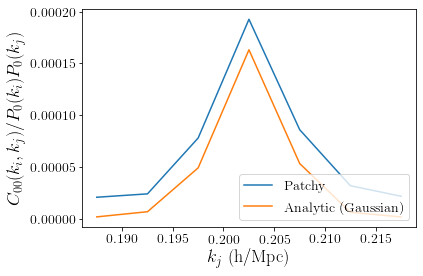

In [28]:
plt.plot(kplot,CovaPatchy[kt,kt-3:kt+4]/norm)
plt.plot(kplot,Cij(kt)[:,0]/norm)
plt.xlabel(r'$k_j$ (h/Mpc)'); plt.ylabel(r'$C_{00}(k_i,k_j)/P_0 (k_i) P_0(k_j)$')
plt.legend(["Patchy","Analytic (Gaussian)"], loc=4)
# The constant offset is due to the Non-Gaussian covariance which is not added here.
# As only a few k1-modes are sampled (kmodes_sampled) in this run, there is a bit of noise
# (same case for both panels below)

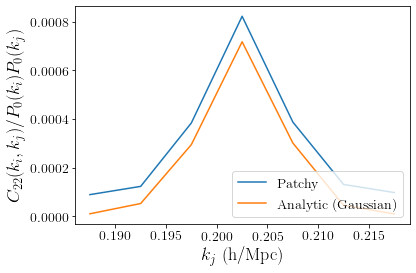

In [29]:
plt.plot(kplot,CovaPatchy[50+kt,50+kt-3:50+kt+4]/norm)
plt.plot(kplot,Cij(kt)[:,1]/norm)
plt.xlabel(r'$k_j$ (h/Mpc)'); plt.ylabel(r'$C_{22}(k_i,k_j)/P_0 (k_i) P_0(k_j)$')
plt.legend(["Patchy","Analytic (Gaussian)"], loc=4)

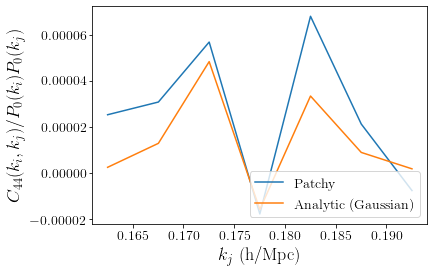

In [38]:
plt.plot(kplot,CovaPatchy[50+kt,kt-3:kt+4]/norm)
plt.plot(kplot,Cij(kt)[:,3]/norm)
plt.xlabel(r'$k_j$ (h/Mpc)'); plt.ylabel(r'$C_{44}(k_i,k_j)/P_0 (k_i) P_0(k_j)$')
plt.legend(["Patchy","Analytic (Gaussian)"], loc=4)

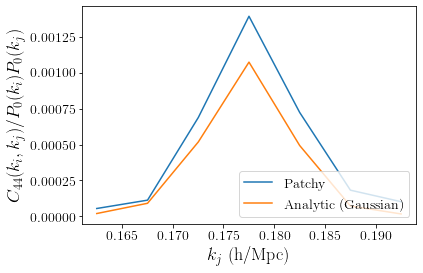

In [36]:
plt.plot(kplot,CovaPatchy[100+kt,100+kt-3:100+kt+4]/norm)
plt.plot(kplot,Cij(kt)[:,2]/norm)
plt.xlabel(r'$k_j$ (h/Mpc)'); plt.ylabel(r'$C_{44}(k_i,k_j)/P_0 (k_i) P_0(k_j)$')
plt.legend(["Patchy","Analytic (Gaussian)"], loc=4)

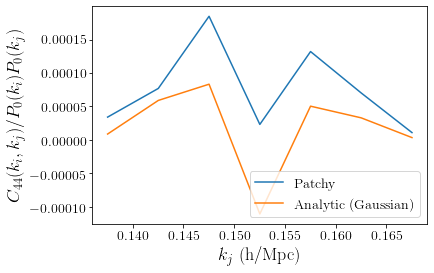

In [56]:
plt.plot(kplot,CovaPatchy[100+kt,50+kt-3:50+kt+4]/norm)
plt.plot(kplot,Cij(kt)[:,5]/norm)
plt.xlabel(r'$k_j$ (h/Mpc)'); plt.ylabel(r'$C_{44}(k_i,k_j)/P_0 (k_i) P_0(k_j)$')
plt.legend(["Patchy","Analytic (Gaussian)"], loc=4)

# Calculating full covariance matrix

In [8]:
#Linear power spectrum from Class or CAMB
pdata=np.loadtxt(dire+'Pk_lin_CAMB.dat')
Plin=InterpolatedUnivariateSpline(pdata[:,0], pdata[:,1])